# **INDICADORES FINANZAS BASICAS**

In [1]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=bac5ca81a4ea9b401cb4f508856cd4d1947cccb58571aca7bc80e4168d458101
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import ta
import time
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

2025-10-21 22:08:44.655577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761084525.079595      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761084525.187059      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# CREAR FUNCIONES
def acciones(name):
  ticker = yf.Ticker(name)
  df_transacciones = ticker.history(period="max")
  df_transacciones=df_transacciones.reset_index()
  return df_transacciones
df=acciones("KO")
df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
16054,2025-10-15 00:00:00-04:00,67.269997,67.720001,66.919998,67.080002,11193700,0.0,0.0
16055,2025-10-16 00:00:00-04:00,67.180000,68.110001,67.160004,67.589996,15707200,0.0,0.0
16056,2025-10-17 00:00:00-04:00,68.000000,68.500000,67.800003,68.440002,15541800,0.0,0.0
16057,2025-10-20 00:00:00-04:00,68.430000,68.639999,67.919998,68.440002,17786800,0.0,0.0
16058,2025-10-21 00:00:00-04:00,70.565002,71.389999,70.230003,71.220001,33620531,0.0,0.0


## **Indicadores de tendencia (como las EMAs)**

In [5]:
import numpy as np
import pandas as pd

def calcular_indicadores_tecnicos(df, col_close="Close", ema1=20, ema2=50):
    """
    Calcula indicadores técnicos comunes sobre un DataFrame de precios.

    Indicadores incluidos:
        - EMA (Exponential Moving Average)
        - Señales de cruce EMA (Buy/Sell)
        - RSI (Relative Strength Index)
        - MACD (Moving Average Convergence Divergence)
        - ADX (+DI / -DI / Fuerza de tendencia)

    Parámetros:
        df (pd.DataFrame): DataFrame con columnas 'Close', 'High', 'Low'.
        col_close (str): Nombre de la columna del precio de cierre.
        ema1 (int): Período de la EMA corta (por defecto 20).
        ema2 (int): Período de la EMA larga (por defecto 50).

    Retorna:
        pd.DataFrame: Copia del DataFrame con las columnas añadidas:
                      EMA{ema1}, EMA{ema2}, Signal, Crossover,
                      RSI, MACD, Signal_MACD, Histograma, ADX, +DI, -DI.
    """
    # ✅ Copiar para no modificar el DataFrame original
    df = df.copy()

    # ======================
    # 1️⃣ Cálculo de EMAs
    # ======================
    df[f"EMA{ema1}"] = df[col_close].ewm(span=ema1, adjust=False).mean()
    df[f"EMA{ema2}"] = df[col_close].ewm(span=ema2, adjust=False).mean()

    # ======================
    # 2️⃣ Señales de cruce (Buy/Sell)
    # ======================
    df["Signal"] = 0
    df.loc[df[f"EMA{ema1}"] > df[f"EMA{ema2}"], "Signal"] = 1   # Tendencia alcista
    df.loc[df[f"EMA{ema1}"] < df[f"EMA{ema2}"], "Signal"] = -1  # Tendencia bajista

    # Detectar cambios de señal (de 1 a -1 o viceversa)
    df["Crossover"] = df["Signal"].diff()

    # ======================
    # 3️⃣ RSI (Relative Strength Index)
    # ======================
    delta = df[col_close].diff()
    gain = delta.clip(lower=0)           # Solo ganancias
    loss = -delta.clip(upper=0)          # Solo pérdidas

    period = 14
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()

    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # ======================
    # 4️⃣ MACD (Convergencia/Divergencia de Medias)
    # ======================
    ema12 = df[col_close].ewm(span=12, adjust=False).mean()
    ema26 = df[col_close].ewm(span=26, adjust=False).mean()
    df["MACD"] = ema12 - ema26
    df["Signal_MACD"] = df["MACD"].ewm(span=9, adjust=False).mean()
    df["Histograma"] = df["MACD"] - df["Signal_MACD"]

    # ======================
    # 5️⃣ ADX (Average Directional Index)
    # ======================
    # Calcular variaciones previas
    df["High_prev"] = df["High"].shift(1)
    df["Low_prev"] = df["Low"].shift(1)
    df["Close_prev"] = df["Close"].shift(1)

    # Movimiento direccional
    df["UpMove"] = df["High"] - df["High_prev"]
    df["DownMove"] = df["Low_prev"] - df["Low"]

    df["+DM"] = np.where((df["UpMove"] > df["DownMove"]) & (df["UpMove"] > 0), df["UpMove"], 0)
    df["-DM"] = np.where((df["DownMove"] > df["UpMove"]) & (df["DownMove"] > 0), df["DownMove"], 0)

    # Rango verdadero (True Range)
    df["TR"] = df[["High", "Low", "Close_prev"]].apply(
        lambda x: max(
            x["High"] - x["Low"],
            abs(x["High"] - x["Close_prev"]),
            abs(x["Low"] - x["Close_prev"])
        ), axis=1
    )

    # Promedios móviles de 14 períodos
    df["+DM14"] = df["+DM"].rolling(14).sum()
    df["-DM14"] = df["-DM"].rolling(14).sum()
    df["TR14"] = df["TR"].rolling(14).sum()

    # Cálculo de +DI, -DI y ADX
    df["+DI"] = 100 * (df["+DM14"] / df["TR14"])
    df["-DI"] = 100 * (df["-DM14"] / df["TR14"])
    df["DX"] = 100 * abs(df["+DI"] - df["-DI"]) / (df["+DI"] + df["-DI"])
    df["ADX"] = df["DX"].rolling(14).mean()

    # ======================
    # 6 Bandas de Bollinger (BB)
    # ======================
    window = 20  # Ventana de 20 días (la más común)
    df['SMA']=df['Close'].rolling(window=window).mean()
    df['STD'] = df['Close'].rolling(window=window).std()
    # Bandas superior e inferior
    df['Upper'] = df['SMA'] + (df['STD'] * 2)
    df['Lower'] = df['SMA'] - (df['STD'] * 2)

    # ======================
    # 7 Calcular SAR Parabólico
    # ======================
    df["SAR"] = ta.trend.PSARIndicator(
        high=df["High"],
        low=df["Low"],
        close=df["Close"],
        step=0.02,
        max_step=0.2
    ).psar()

    # ===============================
    # 8️⃣ Volumen en Balance (OBV)
    # ===============================

    df["OBV"] = (np.sign(df["Close"].diff()) * df["Volume"]).fillna(0).cumsum()

    # Eliminar columnas intermedias opcionalmente
    df.drop(columns=["High_prev", "Low_prev", "Close_prev", "UpMove", "DownMove", "+DM", "-DM", "TR",
                     "+DM14", "-DM14", "TR14", "DX"], inplace=True, errors="ignore")

    return df



In [6]:
df = calcular_indicadores_tecnicos(df)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA20,EMA50,...,Histograma,+DI,-DI,ADX,SMA,STD,Upper,Lower,SAR,OBV
0,1962-01-02 00:00:00-05:00,0.045368,0.046604,0.045368,0.045368,806400,0.0,0.0,0.045368,0.045368,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045368,0.0
1,1962-01-03 00:00:00-05:00,0.044695,0.044695,0.043684,0.044358,1574400,0.0,0.0,0.045272,0.045329,...,-0.000065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044358,-1574400.0
2,1962-01-04 00:00:00-05:00,0.044470,0.045032,0.044470,0.044695,844800,0.0,0.0,0.045217,0.045304,...,-0.000080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043684,-729600.0
3,1962-01-05 00:00:00-05:00,0.044695,0.045256,0.043572,0.043684,1420800,0.0,0.0,0.045071,0.045240,...,-0.000150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.046604,-2150400.0
4,1962-01-08 00:00:00-05:00,0.043347,0.043347,0.042392,0.043235,2035200,0.0,0.0,0.044896,0.045162,...,-0.000213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.046543,-4185600.0


**OVB**
La lógica es esta:

* Si el precio sube y hay volumen alto, significa que los compradores dominan.

* Si el precio sube pero el OBV no sube, significa que no hay apoyo real (falsa subida).

* Si el precio baja y el OBV baja, hay presión vendedora real.

* Si el precio baja pero el OBV sube, puede haber acumulación (manos fuertes comprando en silencio)

In [7]:
def graficos_tecnicos(df, meses=6):
    """
    Genera gráficos técnicos (EMA, RSI, MACD, ADX, Bandas de Bollinger)
    filtrando los últimos 'meses' de datos.

    Parámetros:
    - df: DataFrame con columnas ['Date', 'Close', 'EMA20', 'EMA50', 'RSI', 
                                  'MACD', 'Signal_MACD', 'Histograma', 'ADX', '+DI', '-DI', 
                                  'SMA', 'Upper', 'Lower', 'Crossover']
    - meses: int, cantidad de meses hacia atrás desde la fecha más reciente
    """

    # ===============================
    # 1️⃣ Filtrar rango de fechas
    # ===============================
    fecha_limite = df["Date"].max() - pd.DateOffset(months=meses)
    df_filtro = df[df["Date"] >= fecha_limite]

    # ===============================
    # 2️⃣ Cruces EMA20 / EMA50
    # ===============================
    buy_signals = df_filtro[df_filtro["Crossover"] == 2]
    sell_signals = df_filtro[df_filtro["Crossover"] == -2]

    plt.figure(figsize=(12,6))
    sns.lineplot(data=df_filtro, x="Date", y="Close", label="Close", color="black", linewidth=1.5)
    sns.lineplot(data=df_filtro, x="Date", y="EMA20", label="EMA 20", color="blue", linewidth=2)
    sns.lineplot(data=df_filtro, x="Date", y="EMA50", label="EMA 50", color="red", linewidth=2)
    plt.scatter(buy_signals["Date"], buy_signals["Close"], marker="^", color="green", s=100, label="Buy")
    plt.scatter(sell_signals["Date"], sell_signals["Close"], marker="v", color="red", s=100, label="Sell")
    plt.title(f"Cruces EMA20 vs EMA50 (últimos {meses} meses)")
    plt.xlabel("Fecha"); plt.ylabel("Precio ($)")
    plt.legend(); plt.grid(True)
    plt.show()

    # ===============================
    # 3️⃣ Precio + RSI
    # ===============================
    plt.style.use("seaborn-v0_8-darkgrid")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True, gridspec_kw={'height_ratios':[3,1]})

    sns.lineplot(data=df_filtro, x="Date", y="Close", label="Precio Close", color="black", ax=ax1)
    sns.lineplot(data=df_filtro, x="Date", y="EMA20", label="EMA 20", color="blue", ax=ax1)
    sns.lineplot(data=df_filtro, x="Date", y="EMA50", label="EMA 50", color="red", ax=ax1)
    ax1.set_title(f"Precio + EMA20 / EMA50 (Últimos {meses} meses)")
    ax1.set_ylabel("Precio ($)")
    ax1.legend()

    sns.lineplot(data=df_filtro, x="Date", y="RSI", label="RSI (14 días)", color="purple", ax=ax2)
    ax2.axhline(70, color="red", linestyle="--", label="Sobrecompra (70)")
    ax2.axhline(30, color="green", linestyle="--", label="Sobreventa (30)")
    ax2.set_ylabel("RSI"); ax2.set_xlabel("Fecha")
    ax2.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

    # ===============================
    # 4️⃣ MACD
    # ===============================
    plt.figure(figsize=(12,8))
    plt.subplot(2,1,1)
    plt.plot(df_filtro['Date'], df_filtro["Close"], label="Precio", color="black")
    plt.title(f"Precio vs MACD (últimos {meses} meses)")
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(df_filtro['Date'], df_filtro["MACD"], label="MACD", color="blue")
    plt.plot(df_filtro['Date'], df_filtro["Signal_MACD"], label="Señal", color="red")
    plt.bar(df_filtro['Date'], df_filtro["Histograma"], label="Histograma", color="gray")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ===============================
    # 5️⃣ ADX
    # ===============================
    plt.figure(figsize=(10,6))
    sns.lineplot(data=df_filtro, x="Date", y="ADX", color="orange", label="ADX")
    sns.lineplot(data=df_filtro, x="Date", y="+DI", color="green", label="+DI")
    sns.lineplot(data=df_filtro, x="Date", y="-DI", color="red", label="-DI")
    plt.axhline(25, color="gray", linestyle="--", label="Tendencia Fuerte (25)")
    plt.title(f"ADX (Fuerza de la tendencia) - últimos {meses} meses")
    plt.legend()
    plt.show()

    # ===============================
    # 6️⃣ Bandas de Bollinger
    # ===============================
    plt.figure(figsize=(10,6))
    sns.lineplot(data=df_filtro, x="Date", y="Close", color="blue", label="Precio Cierre")
    sns.lineplot(data=df_filtro, x="Date", y="SMA", color="orange", label="SMA 20D")
    sns.lineplot(data=df_filtro, x="Date", y="Upper", color="green", linestyle='--', label="Banda Superior")
    sns.lineplot(data=df_filtro, x="Date", y="Lower", color="red", linestyle='--', label="Banda Inferior")
    plt.fill_between(df_filtro['Date'], df_filtro['Lower'], df_filtro['Upper'], color='gray', alpha=0.1)
    plt.title(f"Bandas de Bollinger (últimos {meses} meses)")
    plt.xlabel('Fecha'); plt.ylabel('Precio ($)')
    plt.legend()
    plt.show()

    # ===============================
    # 7 SAR PARABOLICO
    # ===============================
    plt.figure(figsize=(12,6))
    sns.lineplot(data=df_filtro, x="Date", y="Close", color="black", label="Precio Close", linewidth=1.5)
    plt.scatter(df_filtro["Date"], df_filtro["SAR"], color="magenta", s=40, label="SAR Parabólico")
    plt.title(f"Precio y SAR Parabólico (últimos {meses} meses)")
    plt.xlabel("Fecha")
    plt.ylabel("Precio ($)")
    plt.legend()
    plt.grid(True)
    plt.show()


    # ===============================
    # 8️⃣ Volumen en Balance (OBV)
    # ===============================
    fig, ax1 = plt.subplots(figsize=(12,6))
    sns.lineplot(data=df_filtro, x="Date", y="Close", color="black", label="Precio Close", ax=ax1)
    ax1.set_ylabel("Precio ($)", color="black")
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    sns.lineplot(data=df_filtro, x="Date", y="OBV", color="blue", label="OBV", ax=ax2)
    ax2.set_ylabel("OBV", color="blue")
    ax2.legend(loc="upper right")

    plt.title(f"Precio vs OBV (últimos {meses} meses)")
    plt.grid(True)
    plt.show()

    print(f"✅ Gráficos generados correctamente para los últimos {meses} meses.")



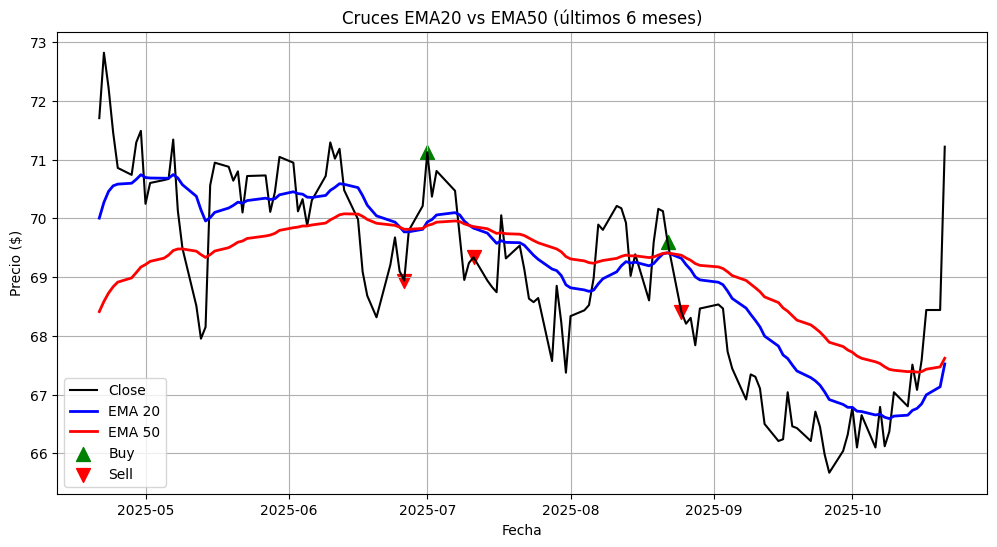

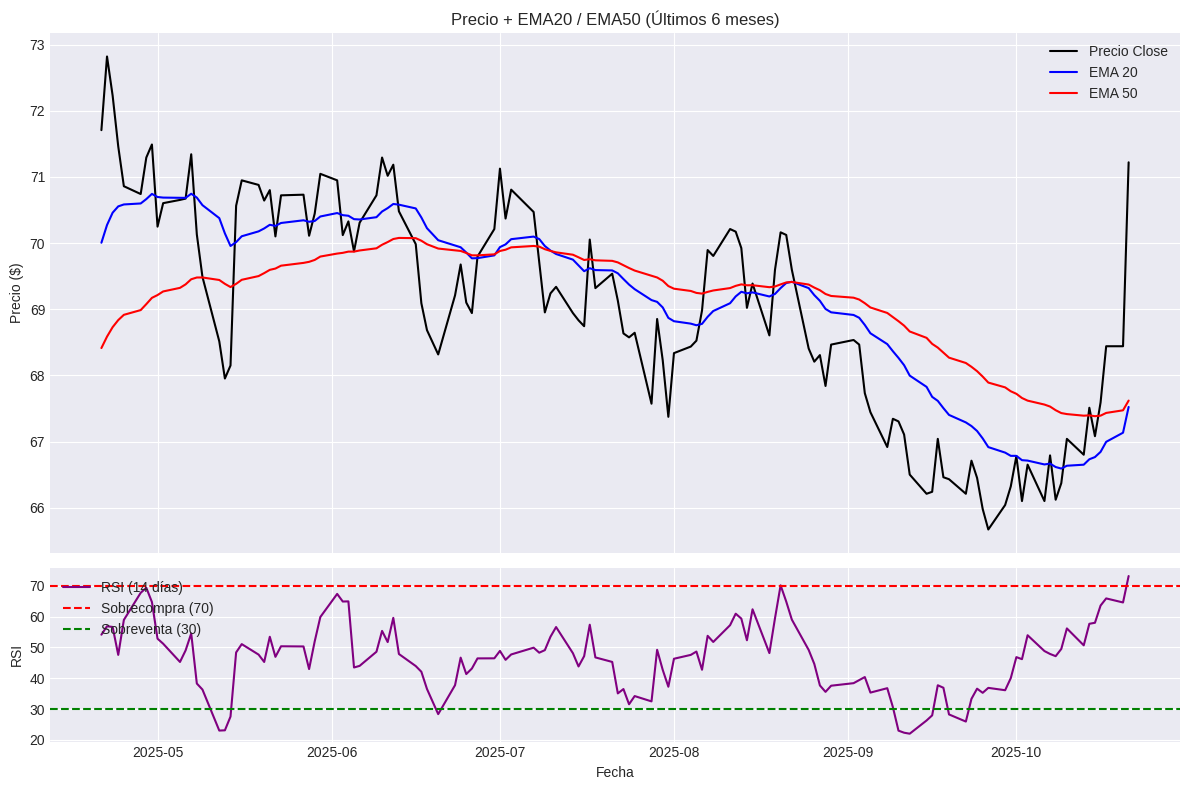

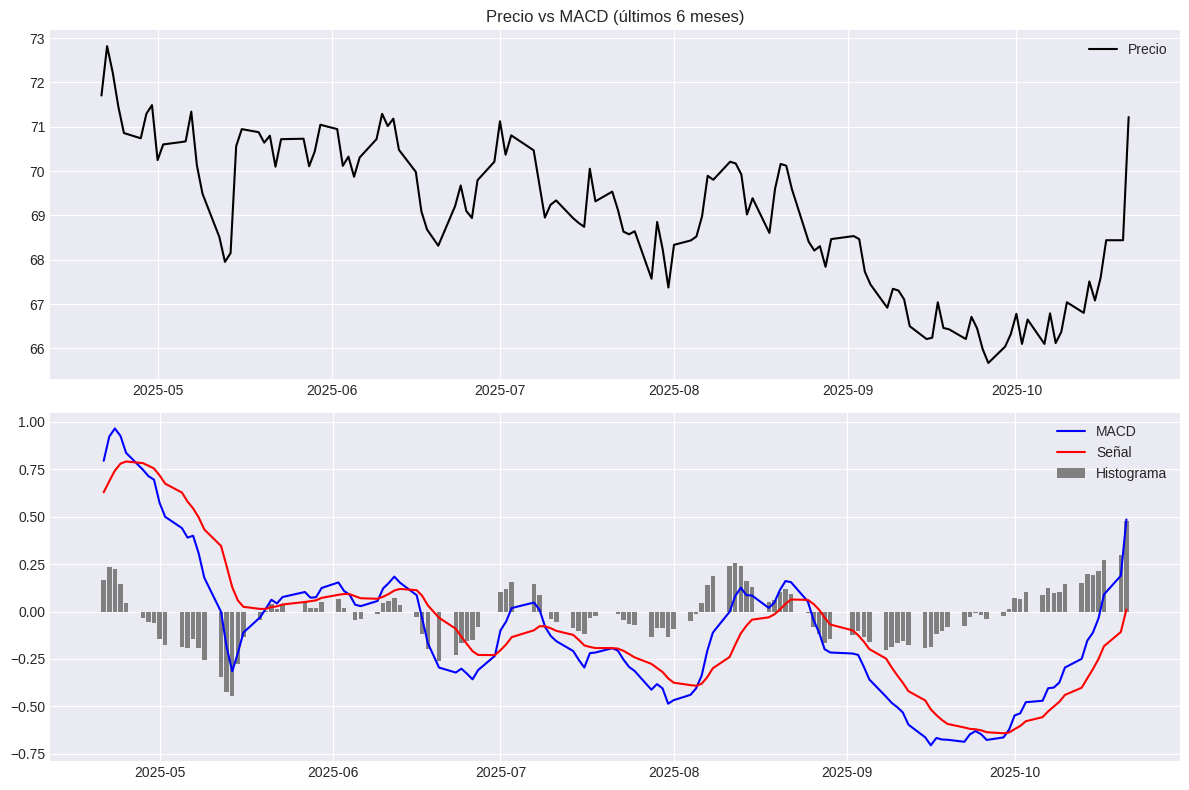

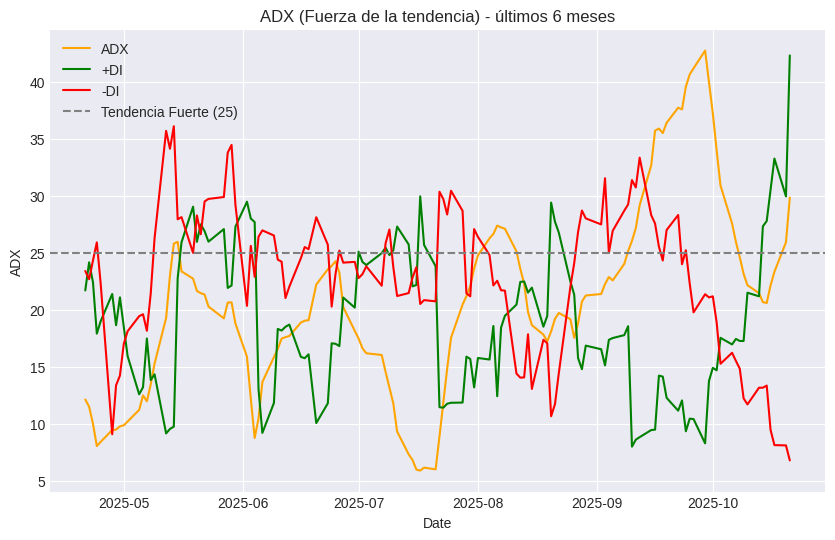

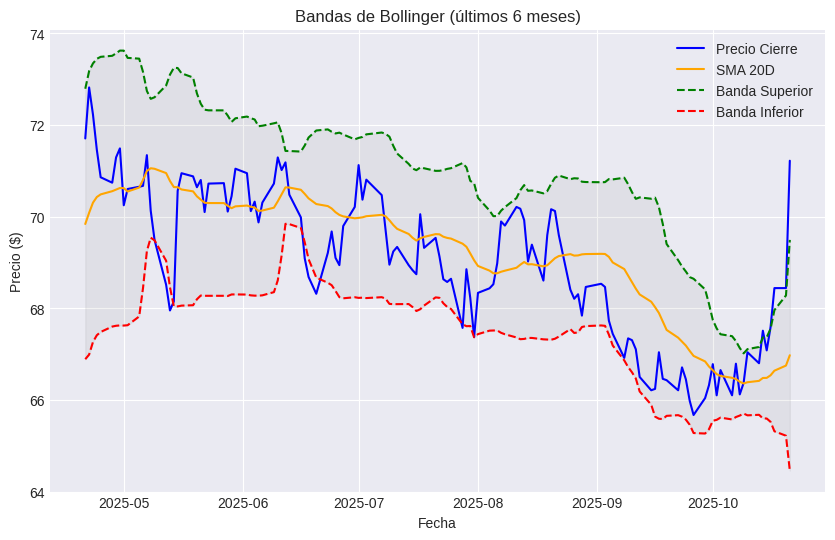

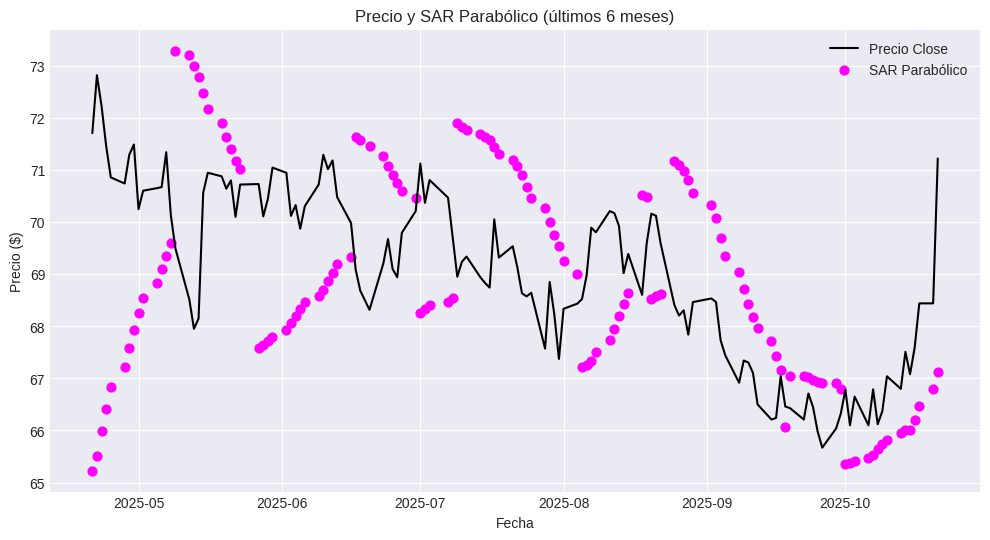

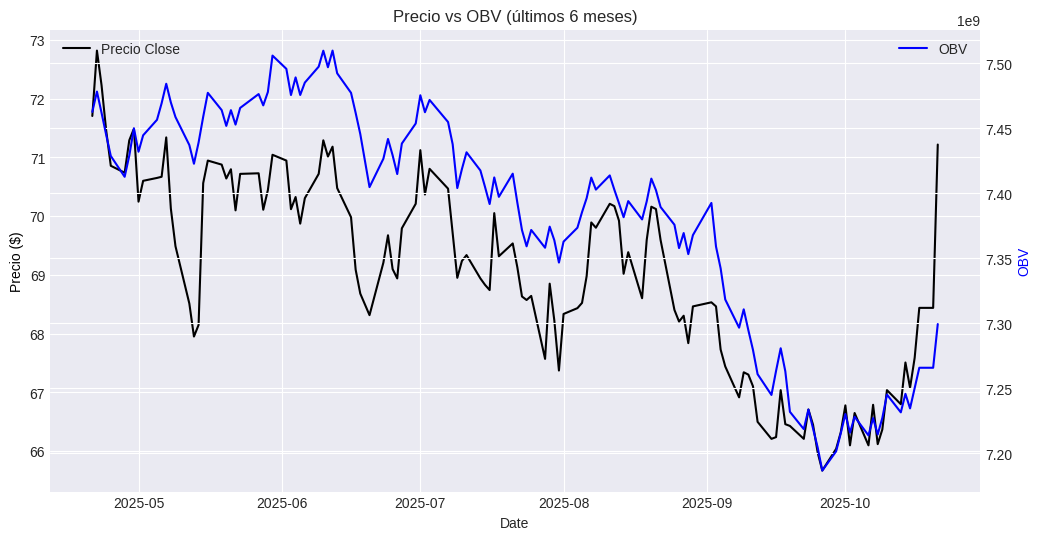

✅ Gráficos generados correctamente para los últimos 6 meses.


In [8]:
graficos_tecnicos(df, meses=6)

| Indicador               | Qué te dice                        | Señales clave                                                                                                         |
| ----------------------- | ---------------------------------- | --------------------------------------------------------------------------------------------------------------------- |
| **EMA20 vs EMA50**      | Dirección y fuerza de la tendencia | Cruce EMA20 sobre EMA50 → señal de compra (tendencia alcista).<br>Cruce EMA20 bajo EMA50 → venta (tendencia bajista). |
| **RSI (14 días)**       | Momentum del mercado               | <30 → sobreventa (rebote posible).<br>>70 → sobrecompra (puede corregir).                                             |
| **MACD**                | Confirma cambios de tendencia      | Cruce al alza del MACD sobre su señal → compra.<br>Cruce a la baja → venta.                                           |
| **ADX**                 | Mide la fuerza de la tendencia     | ADX > 25 = tendencia fuerte.<br>ADX < 20 = mercado lateral (evita operar mucho).                                      |
| **Bandas de Bollinger** | Volatilidad y zonas extremas       | Precio tocando banda inferior → posible compra.<br>Precio tocando banda superior → posible toma de ganancias.         |
| **SAR Parabólico**      | Seguimiento de tendencia           | Puntos SAR debajo del precio → tendencia alcista.<br>Encima del precio → bajista.                                     |
| **OBV**                 | Flujo de volumen (confirmación)    | OBV subiendo junto con precio = movimiento real.<br>Divergencia OBV bajando = posible debilidad.                      |


💡 Estrategia típica de análisis al cierre (swing / mediano plazo)

Esperas el cierre diario para evitar ruido intradía.

Analizas la confluencia de señales:

* EMA20 cruza hacia arriba la EMA50.

* RSI entre 40 y 60 (inicio de nueva tendencia).

* MACD cruza al alza su señal.

* ADX > 25 (confirmación de fuerza).

* OBV subiendo (entrada de dinero).

* Confirmas con SAR o Bollinger para afinar el punto de entrada.

* Entrada: al día siguiente del cierre, si la tendencia se confirma.

Salida / toma de ganancia:

* Cruce bajista de EMA20/EMA50.

* RSI > 70.

* MACD cruza a la baja.

* OBV empieza a caer.

**MACD**

🔼 Señal de compra:
Cuando la línea MACD cruza hacia arriba la Signal, indica que el impulso cambia a alcista.
(El MACD sube más rápido que su media → aumento de momentum positivo)

🔽 Señal de venta:
Cuando la línea MACD cruza hacia abajo la Signal, el impulso cambia a bajista.
(El MACD cae por debajo de su media → pérdida de momentum)

**ADX**

* Cuando +DI cruza sobre −DI → señal alcista.

* Cuando −DI cruza sobre +DI → señal bajista.

* Cuando ADX > 25 → tendencia fuerte.

* Cuando ADX < 20 → mercado lateral (sin tendencia).

**Graficar Bandas de Bollinger**

📈 Cuando el precio toca o supera la banda superior → el activo podría estar sobrecomprado (posible corrección a la baja).

📉 Cuando el precio toca o cae por debajo de la banda inferior → el activo podría estar sobrevendido (posible rebote al alza).

🔍 Cuando las bandas se estrechan → baja volatilidad (posible ruptura pronto).

💥 Cuando las bandas se expanden → alta volatilidad o tendencia fuerte.

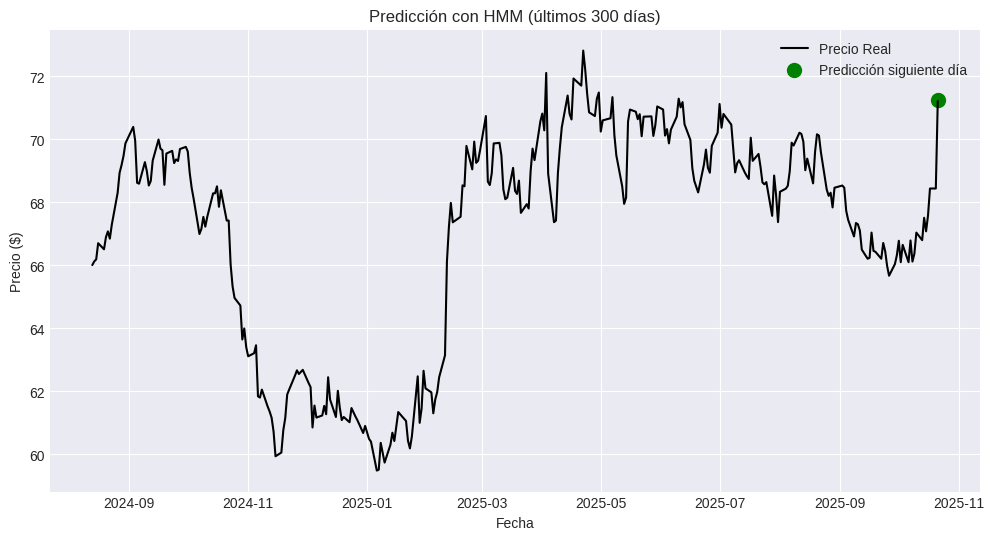

📈 Precio predicho para el siguiente día: 71.24


In [9]:
# ====================================================
# 🔹 FUNCIÓN PARA PREDICCIÓN CON MODELO DE MARKOV (HMM)
# ====================================================
def predict_next_price_markov(df, n_days=300, n_states=3, plot=True):
    """
    Predice el precio del siguiente día usando un Modelo de Markov Oculto (HMM).
    
    Parámetros:
        df (DataFrame): Debe contener columna 'Close' (precio de cierre).
        n_days (int): Número de días recientes para entrenar el modelo.
        n_states (int): Número de estados ocultos del HMM.
        plot (bool): Si True, grafica los precios y la predicción.
        
    Retorna:
        pred_price (float): Predicción del precio para el siguiente día.
        df_result (DataFrame): DataFrame con columna 'Predicted_Price'.
    """
    # --- 1️⃣ Filtrar últimos n_days ---
    df = df.copy()
    df = df.tail(n_days)
    
    # --- 2️⃣ Calcular rendimientos logarítmicos ---
    df["Return"] = np.log(df["Close"] / df["Close"].shift(1))
    df = df.dropna()
    
    # --- 3️⃣ Entrenar el HMM ---
    model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000)
    model.fit(df[["Return"]])
    
    # --- 4️⃣ Predecir el estado actual ---
    hidden_states = model.predict(df[["Return"]])
    last_state = hidden_states[-1]
    
    # --- 5️⃣ Obtener la media del retorno para ese estado ---
    mean_return = model.means_[last_state][0]
    
    # --- 6️⃣ Calcular precio predicho ---
    last_price = df["Close"].iloc[-1]
    pred_price = last_price * np.exp(mean_return)
    
    # --- 7️⃣ Guardar en el DataFrame ---
    df["Predicted_Price"] = np.nan
    df.loc[df.index[-1], "Predicted_Price"] = pred_price
    
    # --- 8️⃣ Graficar ---
    if plot:
        plt.figure(figsize=(12,6))
        plt.plot(df["Date"], df["Close"], label="Precio Real", color="black")
        plt.scatter(df["Date"].iloc[-1], pred_price, color="green", s=100, label="Predicción siguiente día")
        plt.title(f"Predicción con HMM (últimos {n_days} días)")
        plt.xlabel("Fecha")
        plt.ylabel("Precio ($)")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return pred_price, df

# ====================================================
# 🔹 EJEMPLO DE USO
# ====================================================
# Supongamos que tu DataFrame se llama df y tiene columnas ['Date', 'Close']
pred_price, df_result = predict_next_price_markov(df, n_days=300, n_states=3)

print(f"📈 Precio predicho para el siguiente día: {pred_price:.2f}")


In [10]:
df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA20,EMA50,...,Histograma,+DI,-DI,ADX,SMA,STD,Upper,Lower,SAR,OBV
16054,2025-10-15 00:00:00-04:00,67.269997,67.720001,66.919998,67.080002,11193700,0.0,0.0,66.764713,67.382734,...,0.192519,27.800793,13.360989,20.607410,66.480500,0.443509,67.367518,65.593482,66.000000,7.234644e+09
16055,2025-10-16 00:00:00-04:00,67.180000,68.110001,67.160004,67.589996,15707200,0.0,0.0,66.843312,67.390862,...,0.214093,30.530576,9.469412,22.153748,66.537000,0.508042,67.553084,65.520917,66.206400,7.250352e+09
16056,2025-10-17 00:00:00-04:00,68.000000,68.500000,67.800003,68.440002,15541800,0.0,0.0,66.995378,67.432004,...,0.272923,33.279561,8.138608,23.339759,66.637500,0.661417,67.960335,65.314666,66.472904,7.265893e+09
16057,2025-10-20 00:00:00-04:00,68.430000,68.639999,67.919998,68.440002,17786800,0.0,0.0,67.132961,67.471534,...,0.297154,29.959776,8.112459,25.934946,66.749001,0.765355,68.279710,65.218291,66.797240,7.265893e+09
16058,2025-10-21 00:00:00-04:00,70.565002,71.389999,70.230003,71.220001,33620531,0.0,0.0,67.522203,67.618532,...,0.475164,42.328330,6.796780,29.859229,66.974501,1.258673,69.491847,64.457154,67.128936,7.299514e+09
